# Introduction

The notebook is intended to perform a Sales Forecast over the data of the [Tabular Playground Series - September 2022](https://www.kaggle.com/competitions/tabular-playground-series-sep-2022).

Thanks to [this notebook](https://www.kaggle.com/code/jcaliz/tps-sep22-eda-baseline-you-were-looking-for) for the EDA ideas.

In [6]:
# Import Standard Libraries
import pandas as pd
import numpy as np
from itertools import product as cartesian_product
import warnings

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

from xgboost import XGBRegressor

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

# Suppress FutureWarning from Seaborn
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'font.family': 'Andale Mono',
    'axes.titlesize': 24,
    'figure.facecolor': '#E5E8E8',
    'axes.facecolor': '#E5E8E8'
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('deep'), 
              rc=theme_parameters)

In [8]:
# Notebook's variables
kaggle = True

# Read Data

In [9]:
# Switch data path in case of local execution
if kaggle:
    train_data_path = '../input/tabular-playground-series-sep-2022/train.csv'
    test_data_path = '../input/tabular-playground-series-sep-2022/test.csv'
else:
    train_data_path = './../../data/2022_09/train.csv'
    test_data_path = './../../data/2022_09/test.csv'

In [10]:
# Read train and test data
train_data = pd.read_csv(train_data_path,
                         parse_dates=['date'],
                             index_col=0)
test_data = pd.read_csv(test_data_path,
                        parse_dates=['date'],
                        index_col=0)

In [ ]:
train_data.info()

In [ ]:
test_data.info()

# Exploratory Data Analysis

## Null Values

In [ ]:
# Define data to display
data_to_display = {
    'Train Data': train_data,
    'Test Data': test_data
}

# Create figure
figure = plt.figure(tight_layout=True, figsize=(16, 6))


# Define figure's subplots
grid_spec = GridSpec(len(data_to_display), 1)

# Fetch data to plot
for row, (name, data) in enumerate(data_to_display.items()):
    
    # Create subplot
    ax = figure.add_subplot(grid_spec[row, 0])
    
    sns.histplot(data=data.isna().melt(var_name='Feature', value_name='Missing'), 
                 y='Feature', 
                 hue='Missing', 
                 multiple='fill',
                 ax=ax)
    
    # Refactor x label as missing percentage
    ax.xaxis.set_major_locator(ticker.LinearLocator(21))
    ax.xaxis.set_major_formatter('{:.0%}'.format)
    
    # Set title and label
    ax.set_title(name, fontsize=15)
    ax.set_xlabel('Null Percentage', fontweight='bold')

There are no null values, so there is not need to impute the data while training or testing the model.

## Distribution of Sold Product per Country, Store and Product

In [ ]:
# Define the subplot
figure, ax = plt.subplots(12, 4, figsize=(25, 50))
ax = ax.flatten()

# Fetch the data to plot
for index, (combination, data_plot) in enumerate(train_data.groupby(['country', 'store', 'product'])):
    
    sns.histplot(data=data_plot.num_sold, 
                 ax=ax[index])
    
    ax[index].set_title(' | '.join(combination), fontsize=14)

plt.tight_layout()

Most of the countries have a skewed distribution, except Poland. 

## Sold Product per Country

In [ ]:
# Plot the number of sold products per country with respect to product
ax = sns.barplot(data=train_data, 
                 x='product', 
                 y='num_sold', 
                 hue='country')

ax.set_title('Product Sold per Country')

plt.show()

- Every product is sold by every country
- Kaggle for Kids looks like the most sold
- Use both Product and Country as features

## Sold Product per Country over Time

In [ ]:
# Plot the number of sold products per country with respect to time
ax = sns.lineplot(
    data=train_data.groupby([
        train_data.date.dt.strftime('%Y-%m'), train_data.country 
    ])['num_sold'].sum().reset_index(), 
    x='date', 
    y='num_sold', 
    hue='country'
)

ax.set_title('Number of Sold Products per Country')

plt.xticks(rotation=45)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=train_data.date.dt.strftime('%Y-%m').nunique()/2))

plt.show()

- There is a non-stationary point around early 2020
- Year can be used as a feature

## Date Range in Train & Test Data

In [ ]:
# Compute the min and max time range for train & test data
train_range = train_data.date.agg(['min', 'max'])
test_range = test_data.date.agg(['min', 'max'])

# Define the subplot
figure, ax = plt.subplots()

# Plot the train_range time range
ax.plot(train_range, 
        [0.2, 0.2], 
        linewidth=5, 
        marker='.', 
        markersize=30, 
        label='Train')

# Plot test_rage time rage
ax.plot(test_range, 
        [0.3, 0.3], 
        linewidth=5, 
        marker='.', 
        markersize=30, 
        label='Test')

# Refine plot height
ax.set_ylim(0.1, 0.4)
ax.legend()

# Remove the y-ticks since it's not need
ax.set_yticks(ticks=[]);

plt.xticks(fontsize=14)
ax.legend(borderpad=1.5, fontsize=13)

print('Train Data Time Range', train_range, '\n', sep='\n')
print('Test Data Time Range', test_range, sep='\n')
print('\n')

- Since the years between train & test data do not overlap the `year` can not be taken into account as a feature

## Sold Product per Product over Time

In [ ]:
# Define the subplot
figure, ax = plt.subplots(2, 2, figsize=(16, 9))
ax = ax.flatten()
hue_order = train_data['country'].unique()

# Fetch the products
for index, product in enumerate(train_data['product'].unique()):
    
    # Retrieve data
    data_plot = train_data[train_data['product'] == product]
        
    # Plot
    sns.lineplot(data=data_plot.groupby([
                        data_plot.date.dt.strftime('%Y-%m'), 
                        data_plot.country
                        ])['num_sold'].sum().reset_index(), 
                 x='date', 
                 y='num_sold', 
                 hue='country',
                 hue_order=hue_order,
                 ax=ax[index])
    
    # Retrieve legends information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()
    
    # Set the title
    ax[index].set_title(product, fontsize=14)
    ax[index].xaxis.set_major_locator(ticker.MaxNLocator(nbins=data_plot.date.dt.strftime('%Y-%m').nunique()/5))
    
# Set the legend
figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=12,
              ncol=train_data['country'].nunique())
    
plt.tight_layout()

- As per the previous plot, there is a strange behavior in 2020
- `Kaggle Advanced Techniques` and `Kaggle Getting Started` have a month seasonality. It could be useful to use the month as a feature.

## Sold Product per Product & Store over Time

In [ ]:
# Define the subplot
figure, ax = plt.subplots(4, 2, figsize=(16, 12), sharey=True)
ax = ax.flatten()
hue_order = train_data['country'].unique()

# Compute every possible combination between 'product' and 'store'
products = train_data['product'].unique()
stores = train_data['store'].unique()
iterator = cartesian_product(products, stores)

# Fetch the data to plot
for index, (product, store) in enumerate(iterator):
    
    # Retrieve the data to plot
    data_plot = train_data[
        (train_data['store'] == store) &
        (train_data['product'] == product)]
    
    # Plot the data
    sns.lineplot(
        data=data_plot.groupby([
            data_plot.date.dt.strftime('%Y-%m'), 
            data_plot.country
        ])['num_sold'].sum().reset_index(),
        x='date',
        y='num_sold',
        hue='country',
        hue_order=hue_order,
        ax=ax[index])
    
    # Set title
    ax[index].set_title(f'{store} | {product}', 
                        fontsize=10)
    
    # Set bins
    ax[index].xaxis.set_major_locator(ticker.MaxNLocator(nbins=data_plot.date.dt.strftime('%Y-%m').nunique()/5))
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()
    

# Set the legend
figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=12,
              ncol=train_data['country'].nunique())
    
plt.tight_layout()                 

- `KaggleRama` clarly sells less than `KaggleMart`. The store has to be a feature.
- Non-stationary point in 2020
- Monthly seasonality for `Kaggle Advanced Techniques` and `Kaggle Getting Started`

## Seasonality

In [ ]:
def plot_seasonality(seasonality_column, ci=95, alpha=1):
    """
    Utility function for plot the specified seasonality in 'seasonality_column' with respect to the 'product' and 'store' grouping
    
    Parameters:
        seasonality_column:
        ci: Integer confidence interval value
        alpha
    """
    
    # Define the subplots
    figure, ax = plt.subplots(4, 2, figsize=(18, 20))
    ax = ax.flatten()
    hue_order = train_data['country'].unique()
    
    
    # Compute every possible combination between 'product' and 'store'
    products = train_data['product'].unique()
    stores = train_data['store'].unique()
    iterator = cartesian_product(products, stores)
    
    # Fetch the data to plot
    for index, (product, store) in enumerate(iterator):
        
        # Retrieve the data to plot
        data_plot = train_data[
            (train_data['store'] == store) &
            (train_data['product'] == product)]
    
        # Plot the data
        sns.lineplot(
            data=pd.melt(
                data_plot, 
                id_vars=['country', seasonality_column],
                value_vars=['num_sold'],
                value_name='num_solds'
            ),
            x=seasonality_column,
            y='num_solds',
            hue='country',
            ax=ax[index],
            #errorbar=('ci', ci), - New Seaborn version
            ci=ci,
            alpha=alpha,
            hue_order=hue_order
        )
        
        # Set Title
        ax[index].set_title(f'{store} | {product}', 
                             fontsize=12)
        
        # Retrieve legend information
        handles = ax[index].get_legend_handles_labels()[0]
        labels = ax[index].get_legend_handles_labels()[1]
        ax[index].legend().remove()

    # Set the legend
    figure.legend(handles, 
                  labels, 
                  loc='upper center', 
                  bbox_to_anchor=(0.5, 1.03), 
                  fontsize=12,
                  ncol=train_data['country'].nunique())
    
    # Set the figure title
    plt.suptitle(f'Seasonality by {seasonality_column}',
                 fontsize=16)
    
    plt.tight_layout()
    
    plt.show()

### Engineering Date

In [11]:
def engineer_date(data: pd.DataFrame):
    """
    Engineer the 'date' column to retrieve meaningful information such as the day, month, year, day of week, quarter, day of year and week of year
    
    Parameters:
        data: Pandas DataFrame with the 'date' column
    
    Return:
        data: Pandas DataFrame with the engineered date columns
    """
    
    # Day
    data['day'] = data['date'].dt.day
    
    # Month
    data['month'] = data['date'].dt.month
    
    # Year
    data['year'] = data['date'].dt.year
    
    # Day of the week
    data['dayofweek'] = data['date'].dt.dayofweek
    
    # Quarter
    data['quarter'] = data['date'].dt.quarter
    
    # Day of the year
    data['dayofyear'] = data['date'].dt.dayofyear
    
    # Week of the year
    data['weekofyear'] = data['date'].dt.isocalendar().week
    data.loc[data['weekofyear'] > 52, 'weekofyear'] = 52 # Not every year has 53 weeks, so let's cap to 52
    data['weekofyear'] = data['weekofyear'].astype('int64') # Convert back the column to integer

In [12]:
# apply the 'engineer_date' function over the training and test sets
engineer_date(train_data)
engineer_date(test_data)

### Day

In [ ]:
plot_seasonality('day')

- There is a slightly increase toward the end of the month. Create a boolean variable for the last 27-30 days.

### Month

In [ ]:
plot_seasonality('month')

- There is an increasing trend towards the end of the year
- `Kaggle Advanced Techniques` is more popular at the start of the year, while `Kaggle Getting Started`is more popular at the end

### Year

In [ ]:
plot_seasonality('year')

- Quite a strange behavior in 2020, like a convergence point

### Day of Week

In [ ]:
plot_seasonality('dayofweek')

- Increasing trend over the Weekend. It could be usefull to encode it as a feature.

### Quarter

In [ ]:
plot_seasonality('quarter')

- Same seasonality as Month

### Day of Year

In [ ]:
plot_seasonality('dayofyear')

- There is a spike in the final day of the year, probably due to the XMas holiday. Encode a feature for the 24/12 to 01/01.

### Week of the Year

In [ ]:
plot_seasonality('weekofyear')

- Seasonality for the same product is the same across the two different stores
- `Kaggle Advanced Techniques` is more popular at the start of the year, while `Kaggle Getting Started`is more popular at the end
- Spike at the end of the year across all products and all stores

## Conclusions

- Include `product`, `store` and `country` as feature (one-hot encoded)
- Include the `month` as a feature
- Create a boolean variable indicating the end of the month (27 onwards)
- Create a boolean variable indicating the weekend (from Friday onwards)
- Create a boolean variable indicating the XMas holidays (from 24/12 to 01/01)

# Data Preparation

## Product Normalization

In [13]:
# Replace spaces and special characters
train_data['product'] = train_data['product'].str.replace(' ', '_')
train_data['product'] = train_data['product'].str.replace(':', '_')

test_data['product'] = test_data['product'].str.replace(' ', '_')
test_data['product'] = test_data['product'].str.replace(':', '_')

## Feature Engineering

### End of Month

In [14]:
# Set the columns 'endofmonth' equals to 1 if the 'day' is between [27, 31]
train_data['endofmonth'] = np.where((train_data['day'] >= 27) & (train_data['day'] <= 31), 1, 0)

test_data['endofmonth'] = np.where((test_data['day'] >= 27) & (test_data['day'] <= 31), 1, 0)

### Weekend

In [15]:
# Compute 'friday', 'saturday' and 'sunday' columns depending on the column 'dayofweek'
train_data['friday'] = np.where(train_data['dayofweek'] == 4, 1, 0)
train_data['saturday'] = np.where(train_data['dayofweek'] == 5, 1, 0)
train_data['sunday'] = np.where(train_data['dayofweek'] == 6, 1, 0)

test_data['friday'] = np.where(test_data['dayofweek'] == 4, 1, 0)
test_data['saturday'] = np.where(test_data['dayofweek'] == 5, 1, 0)
test_data['sunday'] = np.where(test_data['dayofweek'] == 6, 1, 0)

### XMas

In [16]:
# Set 'xmas' equals to one if the date is between 24/12 and 01/01
train_data['xmas'] = np.where(
    ((train_data['day'] >= 24) & (train_data['day'] <= 31) & (train_data['month'] == 12)) 
    | ((train_data['day'] == 1) &(train_data['month'] == 1)), 1, 0)

test_data['xmas'] = np.where(
    ((test_data['day'] >= 24) & (test_data['day'] <= 31) & (test_data['month'] == 12)) 
    | ((test_data['day'] == 1) &(test_data['month'] == 1)), 1, 0)

## Features and Labels Definition

In [17]:
# Define features and labels
numerical_features = ['day', 
                      'month', 
                      'dayofweek', 
                      'quarter', 
                      'dayofyear', 
                      'weekofyear', 
                      'endofmonth', 
                      'friday', 
                      'saturday', 
                      'sunday', 
                      'xmas']

categorical_features = ['product', 
                        'store', 
                        'country']

labels = ['num_sold']

## Numerical Features

Since there are no NaN values in the data, it is possible to skip the Fill NaN values step.

In [18]:
# Numerical features pipeline
numerical_features_pipeline = Pipeline(steps=[
    ('numerical_scaler', StandardScaler())
])

## Categorical Features

Since there are no NaN values in the data, it is possible to skip the Fill NaN values step.

In [19]:
# Categorical features pipeline
categorical_features_pipeline = Pipeline(steps=[
    ('categorical_one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

## Bundle Data Preprocessing Steps

In [20]:
# Bunlde data preprocessing steps
data_preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_preprocessing', numerical_features_pipeline, numerical_features),
        ('categorical_preprocessing', categorical_features_pipeline, categorical_features)
    ])

# Train & Test Split

In [21]:
# Define X and y for the training set
X = train_data[numerical_features + categorical_features]
y = train_data[labels]

In [22]:
# Split training data into train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Model Training

In [23]:
# Define function to compute the SMAPE
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

In [24]:
# Define the used metrics
metrics = ['smape']

In [25]:
# Initialize DataFrame of model performance
performance = pd.DataFrame(columns=metrics)

## Linear Regression

In [26]:
%%time

# Define the model
model_lr = LinearRegression()

# Define the pipeline
pipe_lr = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('linear_regression', model_lr)
])

# Train the pipeline
pipe_lr.fit(X_train, 
            y_train)

# Get number of sold predictions
predictions_lr = pipe_lr.predict(X_test)

# Model evaluation
smape_lr = round(smape(y_test, predictions_lr), 2)

print('SMAPE: {}%'.format(smape_lr))
print('\n')

SMAPE: 31.5%


CPU times: user 336 ms, sys: 208 ms, total: 544 ms
Wall time: 241 ms


In [27]:
# Update 'performance' DataFrame
performance.loc['linear_regression'] = [smape_lr]

## XGBoost

In [28]:
%%time

# Define the model
model_xgb = XGBRegressor(n_estimators=500)

# Define the pipeline
pipe_xgb = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('xgboost', model_xgb)
])

# Train the pipeline
pipe_xgb.fit(X_train,
             y_train,
             xgboost__verbose=False)

# Get number of sold predictions
predictions_xgb = pipe_xgb.predict(X_test).reshape(-1, 1) # Reshape is necessary for the SMAPE function

# Model evaluation
smape_xgb = round(smape(y_test, predictions_xgb), 2)

print('SMAPE: {}%'.format(smape_xgb))
print('\n')

SMAPE: 9.63%


CPU times: user 1min 4s, sys: 217 ms, total: 1min 4s
Wall time: 16.5 s


In [30]:
# Update 'performance' DataFrame
performance.loc['xgboost'] = [smape_xgb]

# Model Evaluation & Explainability

## Feature Importance

### Linear Regression

### XGBoost

In [43]:
#len(X_train.columns)

14

In [44]:
#pipe_xgb.named_steps['xgboost'].feature_importances_

array([0.00486648, 0.0080283 , 0.01341154, 0.        , 0.01369616,
       0.01377616, 0.        , 0.00251651, 0.00237615, 0.        ,
       0.17508051, 0.01524589, 0.08831463, 0.17608693, 0.0228331 ,
       0.28520158, 0.        , 0.01286807, 0.00362311, 0.01585011,
       0.03408284, 0.07818016, 0.03396174], dtype=float32)

In [ ]:
#pipe_xgb.named_steps['xgboost'].get_score(importance_type='gain')

## Model Comparison

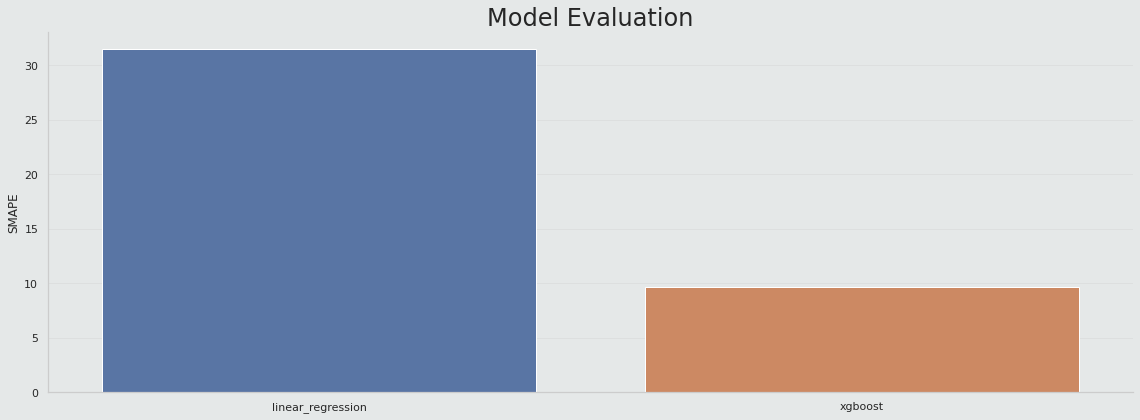

In [31]:
# Plot the models' evaluation metric
ax = sns.barplot(data=performance, 
                 x=performance.index, 
                 y=performance['smape'].values)

ax.set_title('Model Evaluation')

ax.set_ylabel('SMAPE')

plt.tight_layout()

# Submission

In [40]:
# Generate predictions
submission_predictions = pipe_lr.predict(test_data)

In [46]:
# Create submission DataFrame
submission = pd.DataFrame({'row_id': test_data.index, 'num_sold': submission_predictions.reshape(-1,)})

In [47]:
# Write CSV File
submission.to_csv('submission.csv', index=False)